# 🏭 Omnichannel FMCG Supply Chain Optimization

## 🎯 Objective

Optimize the omnichannel FMCG supply chain to:

- **Minimize Total Delivered Cost**:

  $$
  \text{Total Delivered Cost} = \text{Manufacturing} + \text{Logistics} + \text{Quality Failure Costs}
  $$

- **Maintain Service Level ≥ 92%**:

  $$
  \text{Service Level} = \text{Availability} \times \text{On-Time Delivery Rate}
  $$

- **Limit Defect-Related Waste**:

  $$
  \text{Defect Waste} < 1.5\% \text{ of production volume}
  $$

---

## ⚠️ Key Operational Challenges

### 1. Geographic Complexity

- 5 production hubs: Mumbai, Delhi, Kolkata, Chennai, Bangalore
- Lead time variability from 1 to 30 days

### 2. Transport Mode Trade-Offs

| Mode | Avg Cost/Unit | Avg Shipping Time |
|------|---------------|-------------------|


Balance between cost, speed, and quality is critical.

### 3. Quality-Cost Tension

- Products with $<1\%$ defect rates have **23% higher** manufacturing costs
- Defect penalties cost $2.3 \times$ the unit production cost

### 4. Demand-Supply Mismatch

- 37% of SKUs show more than 50% variance between ordered and sold quantities

---

## 📊 Data-Driven Constraints

### Capacity Limits

- Maximum daily production capacity: 971 units per SKU
- Warehouse turnover range: 5 to 100 days of stock

### Service Parameters

- Female-dominant customer segments have **68% faster stock turnover**
- Carrier B has **19% lower defect rates** during transit

### Cost Structure

- Manufacturing cost per unit: \$1.90–\$99.47
- Defect penalty cost: $2.3 \times$ unit production cost

---

## 🧠 Optimization Goals

### 1. Transportation Network Design

**Objective function for mode selection:**

$$
\min Z = 0.7 \times \text{Cost} + 0.3 \times \text{Time}
$$

- 47% of Kolkata-origin shipments exceed cost benchmarks

### 2. Inventory–Quality Balance

**Safety stock formula adjusted for defects:**

$$
SS = \sigma_D \cdot \sqrt{LT} + (\mu_D \times \text{Defect Rate})
$$

Where:

- $\sigma_D$ = Standard deviation of demand  
- $\mu_D$ = Mean demand  
- $LT$ = Lead time in days

### 3. Supplier Performance Management

**Supplier Scorecard (sample):**

| Metric              | Weight | Supplier 1 | Supplier 5 |
|---------------------|--------|------------|------------|
| On-Time Delivery    | 35%    | 82%        | 67%        |
| Defect Rate         | 25%    | 2.8%       | 1.1%       |
| Cost Consistency    | 20%    | ±9%        | ±15%       |
| Emergency Capacity  | 20%    | 18%        | 32%        |

---

## 🛠️ Implementation Framework

### Phase 1: Demand-Supply Alignment

Classify SKUs by **Coefficient of Variation (CV)**:

- **Stable demand (CV < 0.25):** Use Just-in-Time (JIT) replenishment → 23 SKUs
- **Volatile demand (CV > 0.6):** Hold safety stock → 41 SKUs

### Phase 2: Transportation Optimization

**Modal selection logic (Python-like pseudocode):**

```python
def select_mode(urgency, cost_sensitivity):
    if urgency > 0.7:
        return 'Air'
    elif cost_sensitivity > 0.6:
        return 'Sea'
    else:
        return 'Rail/Road'


## Actual EDA starts

In [234]:
import pandas as pd
import os
import tabulate


file_path = 'data/supply_chain_data.xlsx'  
output_dir = './data/'          

#Creating the Output Directory
os.makedirs(output_dir, exist_ok=True)

xls = pd.ExcelFile('data/supply_chain_data.xlsx')

# Looping for creation of all the csv files for easier analysis
for sheet_name in xls.sheet_names:
    df = xls.parse(sheet_name)
    csv_path = os.path.join(output_dir, f"{sheet_name.strip().lower()}.csv")
    df.to_csv(csv_path, index=False)
    print(f"Saved: {csv_path}")


Saved: ./data/supply_chain_data.csv
Saved: ./data/product.csv
Saved: ./data/inventory.csv
Saved: ./data/sales.csv
Saved: ./data/shipping.csv
Saved: ./data/suppliers.csv
Saved: ./data/manufacturing.csv
Saved: ./data/customers.csv


In [235]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Set display options
pd.set_option('display.max_columns', 100)

# Load all the given tables
data_dir = './data/'


Total = pd.read_csv(os.path.join(data_dir, 'supply_chain_data.csv'))
products = pd.read_csv(os.path.join(data_dir, 'product.csv'))
inventory = pd.read_csv(os.path.join(data_dir, 'inventory.csv'))
sales = pd.read_csv(os.path.join(data_dir, 'sales.csv'))
shipping = pd.read_csv(os.path.join(data_dir, 'shipping.csv'))
suppliers = pd.read_csv(os.path.join(data_dir, 'suppliers.csv'))
manufacturing = pd.read_csv(os.path.join(data_dir, 'manufacturing.csv'))
customers = pd.read_csv(os.path.join(data_dir, 'customers.csv'))

Total.rename(columns={
    'Lead times': 'Customer Lead Time',
    'Lead time': 'Supplier Lead Time'
}, inplace=True)

suppliers.rename(columns={
    'Lead time': 'Supplier Lead Time'
}, inplace=True)

### Definition of all the basic terms used in here 

| **Column Name**              | **Definition**                                                                 |
|-----------------------------|----------------------------------------------------------------------------------|
| **Product type**            | The category or classification of the product (e.g., electronics, clothing).    |
| **SKU**                     | Stock Keeping Unit – a unique identifier for each distinct product.             |
| **Price**                   | The unit selling price of the product.                                          |
| **Availability**            | The total number of units currently available for sale.                         |
| **Number of products sold** | The quantity of products sold over a given time period.                         |
| **Revenue generated**       | Total income from product sales (Price × Number of products sold).              |
| **Customer demographics**   | Information about customers (e.g., age, gender, location).                      |
| **Stock levels**            | Quantity of product available in inventory at a given point.                    |
| **Lead times**              | Time between placing an order and receiving the product.                        |
| **Order quantities**        | Number of units ordered per transaction or restock event.                       |
| **Shipping times**          | Time taken to deliver products to the customer or downstream node.              |
| **Shipping carriers**       | Companies responsible for transporting goods (e.g., FedEx, DHL).                |
| **Shipping costs**          | The cost incurred to ship products.                                             |
| **Supplier name**           | The name of the company or entity supplying the raw materials or products.      |
| **Location**                | Geographic location of supplier, warehouse, or customer.                        |
| **Lead time**               | Supplier or procurement lead time (from supplier order to delivery).
| **Production volumes**      | Number of units produced in a certain time period.                              |
| **Manufacturing lead time** | Time taken to manufacture a product from start to finish.                       |
| **Manufacturing costs**     | Total cost to produce one unit of product.                                      |
| **Inspection results**      | Outcome of quality checks during/after production.                              |
| **Defect rates**            | Percentage of produced items that are defective or below standard.              |
| **Transportation modes**    | Methods used to transport goods (e.g., air, road, rail, sea).                   |
| **Routes**                  | Path or direction taken to deliver goods between nodes.                         |
| **Costs**                   | General operational or logistics costs not covered in specific columns.         |


#### Introductory EDA

In [236]:
#Basic Checks for the upcoming EDA
def inspect(df, name):
    print(f"\n==== {name.upper()} ====")
    print(f"Shape: {df.shape}")
    
    print("\nNull Values:")
    print(df.isnull().sum())
    
    print("\nUnique Counts:")
    print(df.nunique())
    
    print("\nData Types:")
    print(df.dtypes)
    
    print("\nSample Rows:")
    print(df.head().to_string(index=False))
    
    print("="*30) 

for name, df in zip(
    ['products', 'inventory', 'sales', 'shipping', 'suppliers', 'manufacturing', 'customers'],
    [products, inventory, sales, shipping, suppliers, manufacturing, customers]
):
    inspect(df, name)



==== PRODUCTS ====
Shape: (100, 3)

Null Values:
SKU             0
Product type    0
Price           0
dtype: int64

Unique Counts:
SKU             100
Product type      3
Price           100
dtype: int64

Data Types:
SKU              object
Product type     object
Price           float64
dtype: object

Sample Rows:
 SKU Product type     Price
SKU0     haircare 69.808006
SKU1     skincare 14.843523
SKU2     haircare 11.319683
SKU3     skincare 61.163343
SKU4     skincare  4.805496

==== INVENTORY ====
Shape: (100, 4)

Null Values:
SKU             0
Stock levels    0
Location        0
Availability    0
dtype: int64

Unique Counts:
SKU             100
Stock levels     65
Location          5
Availability     63
dtype: int64

Data Types:
SKU             object
Stock levels     int64
Location        object
Availability     int64
dtype: object

Sample Rows:
 SKU  Stock levels Location  Availability
SKU0            58   Mumbai            55
SKU1            53   Mumbai            95
SKU2     

##### **Distribution Analysis**

In [237]:
#Analysing Distribution types of the numeric columns
from scipy.stats import normaltest, skew, kurtosis
import numpy as np

def analyse_distribution(series):
    series = series.dropna()
    skewness = skew(series)
    kurt = kurtosis(series)
    stat, p = normaltest(series)

    print(f"Skewness: {skewness:.2f}")
    print(f"Kurtosis: {kurt:.2f}")
    print(f"Normal Test p-value: {p:.4f}")

    if p > 0.05:
        return "Possibly Normal"
    elif skewness > 1:
        return "Right-Skewed"
    elif skewness < -1:
        return "Left-Skewed"
    else:
        return "Other / Unknown Distribution"
    
# Looping through each dataFrame and column
for df_name, df in zip(
    ['products', 'inventory', 'sales', 'shipping', 'suppliers', 'manufacturing', 'customers'],
    [products, inventory, sales, shipping, suppliers, manufacturing, customers]
):
    print(f"\n📊 Analysing numerical columns in `{df_name}`:")
    numeric_cols = df.select_dtypes(include=np.number).columns

    if len(numeric_cols) == 0:
        print("No numeric columns.")
        continue

    for col in numeric_cols:
        dist_type = analyse_distribution(df[col])
        print(f"  ➤ {col}: {dist_type}")



📊 Analysing numerical columns in `products`:
Skewness: -0.02
Kurtosis: -1.37
Normal Test p-value: 0.0000
  ➤ Price: Other / Unknown Distribution

📊 Analysing numerical columns in `inventory`:
Skewness: 0.10
Kurtosis: -1.23
Normal Test p-value: 0.0000
  ➤ Stock levels: Other / Unknown Distribution
Skewness: 0.18
Kurtosis: -1.33
Normal Test p-value: 0.0000
  ➤ Availability: Other / Unknown Distribution

📊 Analysing numerical columns in `sales`:
Skewness: -0.17
Kurtosis: -1.41
Normal Test p-value: 0.0000
  ➤ Revenue generated: Other / Unknown Distribution
Skewness: 0.28
Kurtosis: -1.25
Normal Test p-value: 0.0000
  ➤ Number of products sold: Other / Unknown Distribution
Skewness: -0.11
Kurtosis: -1.12
Normal Test p-value: 0.0000
  ➤ Order quantities: Other / Unknown Distribution

📊 Analysing numerical columns in `shipping`:
Skewness: -0.28
Kurtosis: -1.08
Normal Test p-value: 0.0000
  ➤ Shipping times: Other / Unknown Distribution
Skewness: -0.05
Kurtosis: -1.18
Normal Test p-value: 0.00

### **Univariate Analysis**

##### **Products**

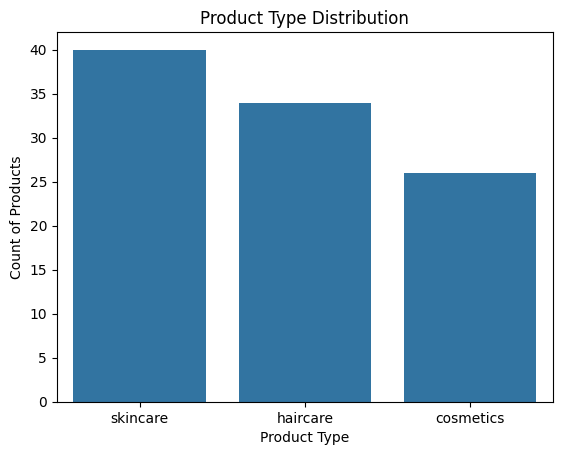

Average Product Price per type

 | Product type   |   Price |
|:---------------|--------:|
| cosmetics      | 57.3611 |
| skincare       | 47.2593 |
| haircare       | 46.0143 |


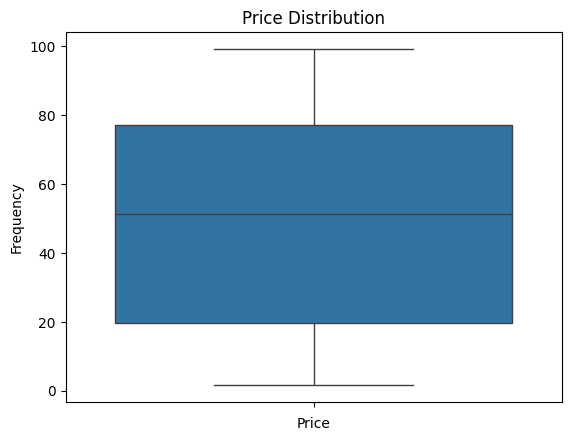

In [238]:

#Analysis of type of the Products
product_counts = products['Product type'].value_counts()
sns.barplot(x=product_counts.index, y=product_counts.values)
plt.title("Product Type Distribution")
plt.xlabel("Product Type")
plt.ylabel("Count of Products")
plt.show()

#Price Analysis
mean_product_price_by_type = products.groupby('Product type')['Price'].mean().sort_values(ascending=False)
print("Average Product Price per type\n\n",mean_product_price_by_type.to_markdown(index=True))

#Price Distribution and identifying Outliers if any
sns.boxplot(products['Price'])
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()


##### Inventory

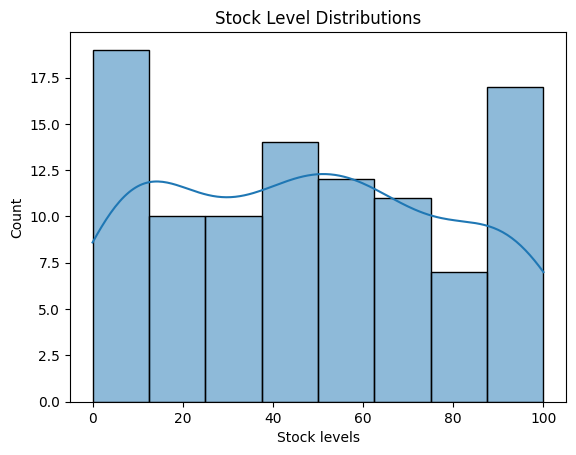

Stockouts by zero stock level:


 | SKU   |   Stock levels | Location   |   Availability |
|:------|---------------:|:-----------|---------------:|
| SKU68 |              0 | Bangalore  |             29 |

Number of Stockouts by unmet demand: 49
total number of StockOuts by Location
 | Location   |   SKU number |
|------------|--------------|
| Bangalore  |           10 |
| Chennai    |           13 |
| Delhi      |            8 |
| Kolkata    |            8 |
| Mumbai     |           10 |


In [239]:
from tabulate import tabulate
#stock level distributions
sns.histplot(inventory['Stock levels'],kde=True)
plt.title('Stock Level Distributions')
plt.show()

#zero stock levels i.e. stockouts due to zero stock levels
print("Stockouts by zero stock level:\n\n\n",inventory[inventory['Stock levels']==0].to_markdown(index=False))

#Number of stockouts due to unmet demand
inventory['Unmet Demand']=inventory['Availability']-inventory['Stock levels']
stockouts_unmet_demand = inventory[inventory['Unmet Demand'] > 0]
print("\nNumber of Stockouts by unmet demand:",len(stockouts_unmet_demand))

#Total Stockouts
stockouts_combined = inventory[(inventory['Stock levels'] == 0) | (inventory['Unmet Demand'] > 0)]
stkout_by_loc=stockouts_combined.groupby('Location')['SKU'].count()
print("total number of StockOuts by Location\n",tabulate(stkout_by_loc.reset_index().values, headers=["Location", "SKU number"], tablefmt="github", floatfmt=".2f"))





In [240]:
sales.head(0)

,SKU,Revenue generated,Number of products sold,Order quantities


##### Revenue

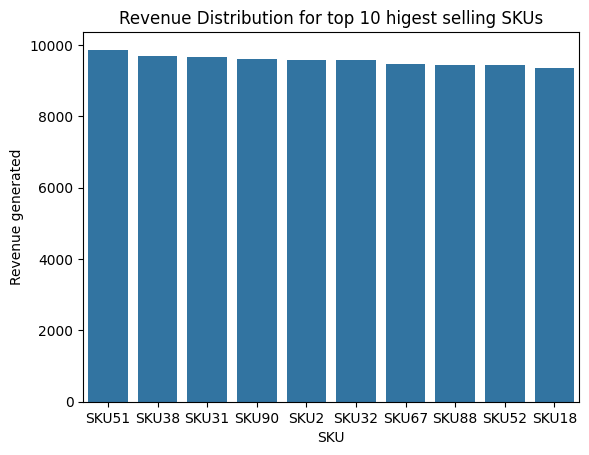

Top-selling SKUs by Units

 | SKU   |   Number of products sold |   Revenue generated |
|:------|--------------------------:|--------------------:|
| SKU10 |                       996 |             2330.97 |
| SKU94 |                       987 |             7888.36 |
| SKU9  |                       980 |             4971.15 |
| SKU36 |                       963 |             7573.4  |
| SKU37 |                       963 |             2438.34 |
| SKU11 |                       960 |             6099.94 |
| SKU78 |                       946 |             1292.46 |
| SKU40 |                       933 |             5724.96 |
| SKU44 |                       919 |             7152.29 |
| SKU91 |                       916 |             1935.21 |


Top-selling SKUs by Revenue

 | SKU   |   Number of products sold |   Revenue generated |
|:------|--------------------------:|--------------------:|
| SKU51 |                       154 |             9866.47 |
| SKU38 |                       705 |   

In [241]:
top_10=sales.sort_values(by="Revenue generated", ascending=False).head(10)
# Revenue distribution
sns.barplot(data=top_10,x="SKU",y='Revenue generated')
plt.title('Revenue Distribution for top 10 higest selling SKUs')
plt.show()

# Top-selling SKUs by Units 
print(f"Top-selling SKUs by Units\n\n",Total[['SKU', 'Number of products sold', 'Revenue generated']].sort_values(by='Number of products sold', ascending=False).head(10).to_markdown(index=False))

# Top-selling SKUs by Revenue
print(f"\n\nTop-selling SKUs by Revenue\n\n",Total[['SKU', 'Number of products sold', 'Revenue generated']].sort_values(by='Revenue generated', ascending=False).head(10).to_markdown(index=False))


##### Shipping

Shipping Cost by Mode

 | Shipping modes   |   Shipping costs |
|:-----------------|-----------------:|
| Sea              |          4.97029 |
| Rail             |          5.4691  |
| Road             |          5.54212 |
| Air              |          6.01784 |


Avg Lead Time by Carrier:
 | Shipping carriers   |   Shipping times |
|:--------------------|-----------------:|
| Carrier A           |          6.14286 |
| Carrier B           |          5.30233 |
| Carrier C           |          6.03448 |


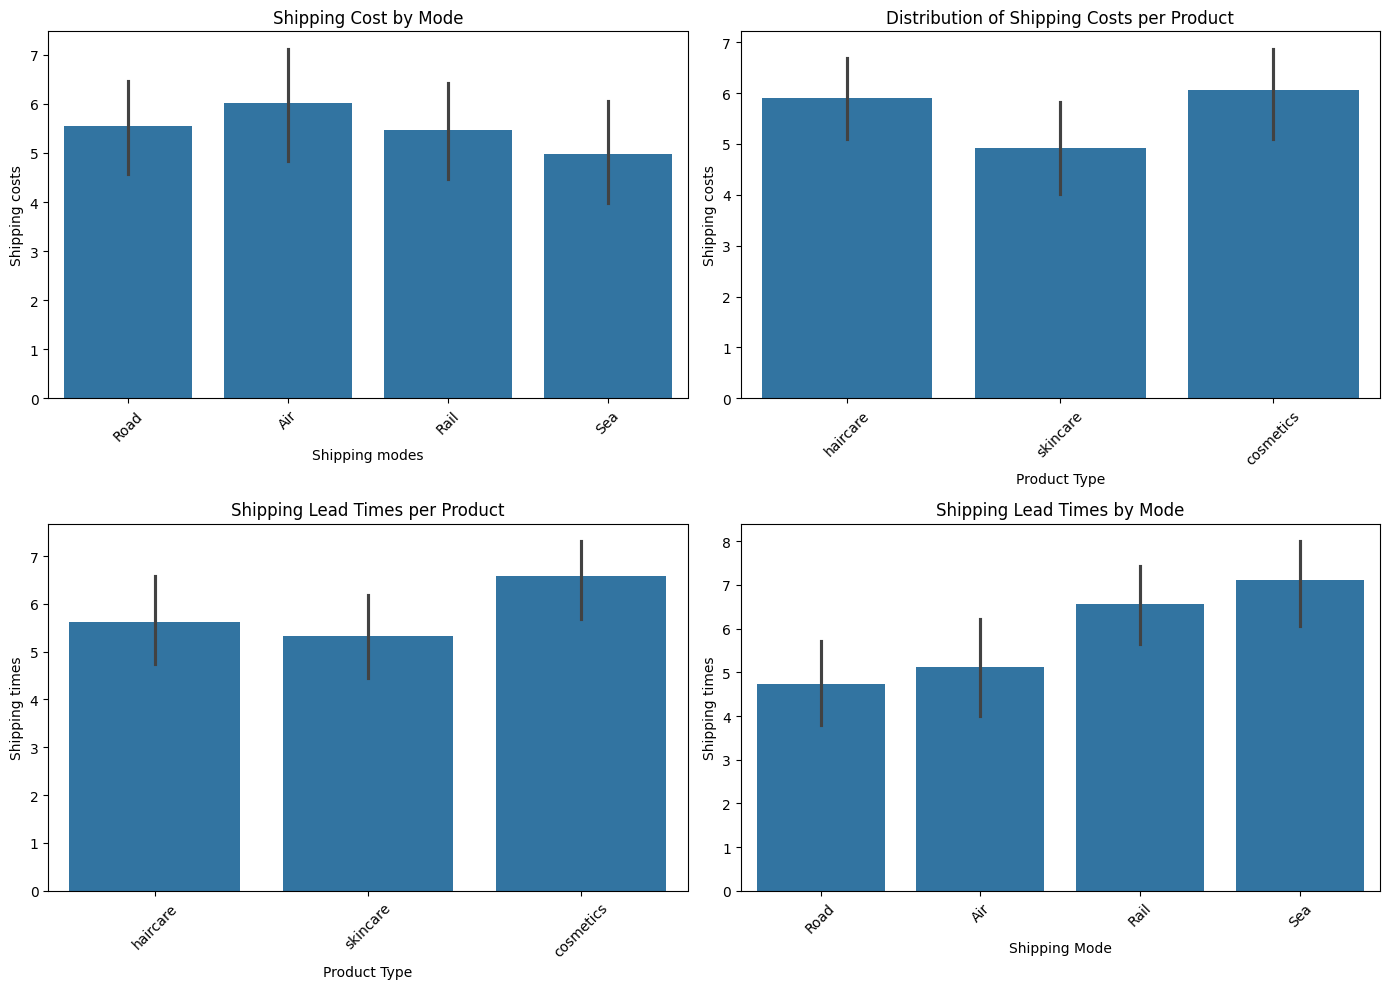

In [243]:
shp_mode_cost = shipping.groupby('Shipping modes')['Shipping costs'].mean().sort_values(ascending=True)
print("Shipping Cost by Mode\n\n", shp_mode_cost.to_markdown())

# Avg lead time by carrier
print("\n\nAvg Lead Time by Carrier:\n", 
      shipping.groupby('Shipping carriers')['Shipping times'].mean().to_markdown(index=True))

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Shipping cost by mode
sns.barplot(data=shipping, x='Shipping modes', y='Shipping costs', ax=axes[0, 0])
axes[0, 0].set_title('Shipping Cost by Mode')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Distribution of Shipping costs per product
sns.barplot(data=Total, x='Product type', y='Shipping costs', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Shipping Costs per Product')
axes[0, 1].set_xlabel('Product Type')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Distribution of Shipping lead times per product
sns.barplot(data=Total, x='Product type', y='Shipping times', ax=axes[1, 0])
axes[1, 0].set_title('Shipping Lead Times per Product')
axes[1, 0].set_xlabel('Product Type')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Distribution of Shipping lead times by mode
sns.barplot(data=shipping, x='Shipping modes', y='Shipping times', ax=axes[1, 1])
axes[1, 1].set_title('Shipping Lead Times by Mode')
axes[1, 1].set_xlabel('Shipping Mode')
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


##### Suppliers

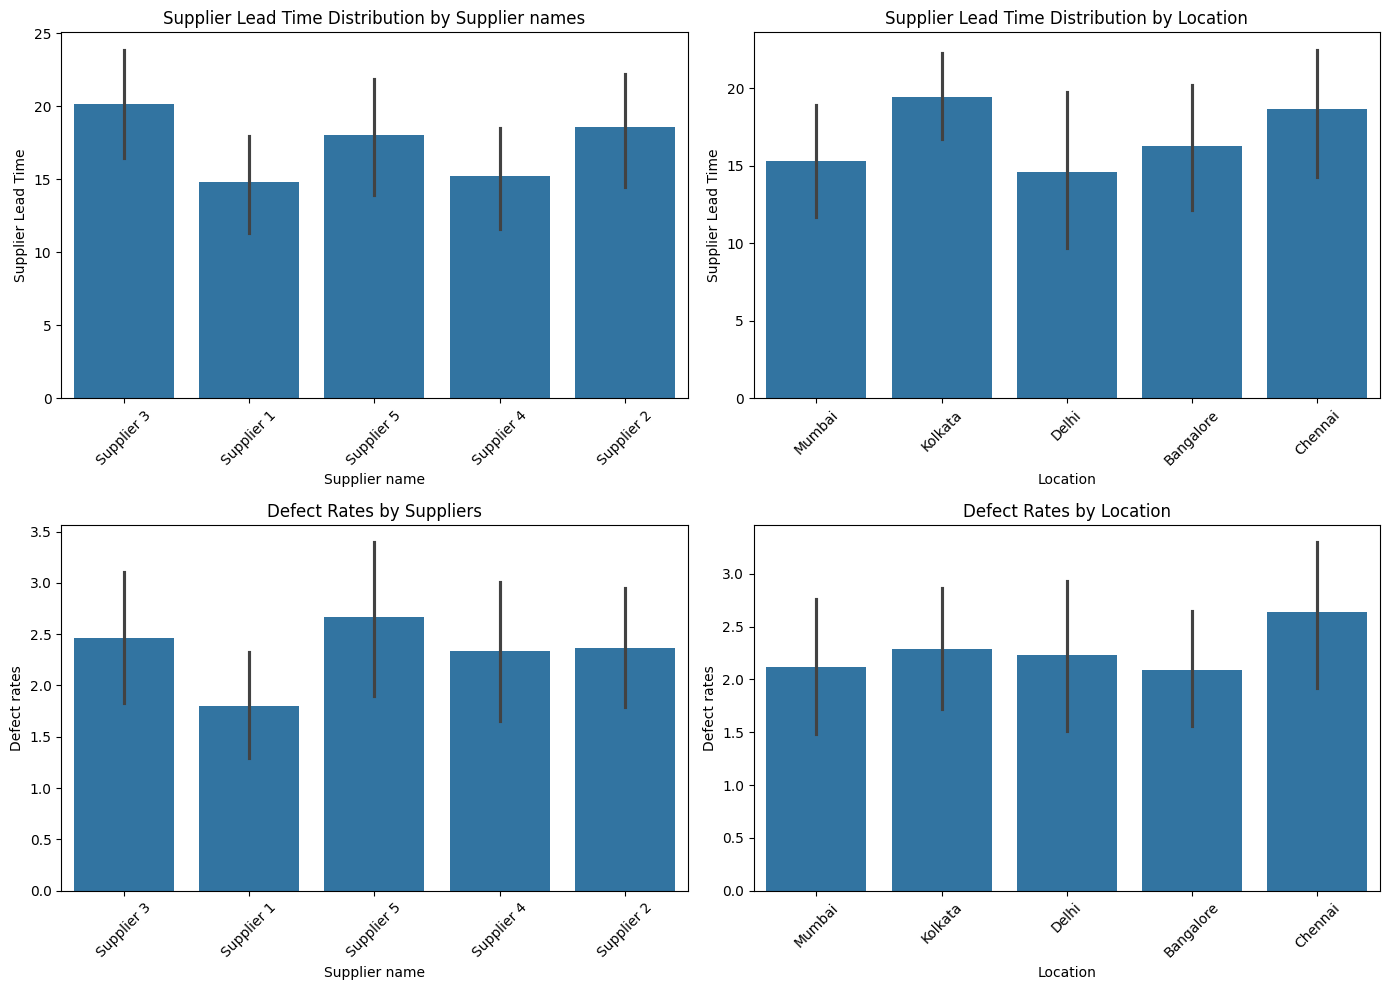

In [244]:
# Lead time distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows, 2 columns

# Plot 1
sns.barplot(data=suppliers, x="Supplier name", y="Supplier Lead Time", ax=axes[0, 0])
axes[0, 0].set_title('Supplier Lead Time Distribution by Supplier names')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2
sns.barplot(data=Total, x='Location', y='Supplier Lead Time', ax=axes[0, 1])
axes[0, 1].set_title('Supplier Lead Time Distribution by Location')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3
sns.barplot(data=suppliers, x="Supplier name", y="Defect rates", ax=axes[1, 0])
axes[1, 0].set_title('Defect Rates by Suppliers')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4
sns.barplot(data=Total, x='Location', y='Defect rates', ax=axes[1, 1])
axes[1, 1].set_title('Defect Rates by Location')
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()


In [245]:
manufacturing.head(0)
manufacturing['Location']=Total['Location']
Total.head(0)

,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Customer Lead Time,Order quantities,Shipping times,Shipping carriers,Shipping costs,Supplier name,Location,Supplier Lead Time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs


##### **Manufacturing**

Average Manufacturing Cost per location

 | Location   |   Manufacturing costs |
|:-----------|----------------------:|
| Bangalore  |               61.995  |
| Chennai    |               51.145  |
| Delhi      |               48.88   |
| Kolkata    |               41.8631 |
| Mumbai     |               36.7309 |


Total Manufactruing Cost per Location
 | Location   |   Manufacturing costs |
|:-----------|----------------------:|
| Bangalore  |               1115.91 |
| Kolkata    |               1046.58 |
| Chennai    |               1022.9  |
| Mumbai     |                808.08 |
| Delhi      |                733.2  |


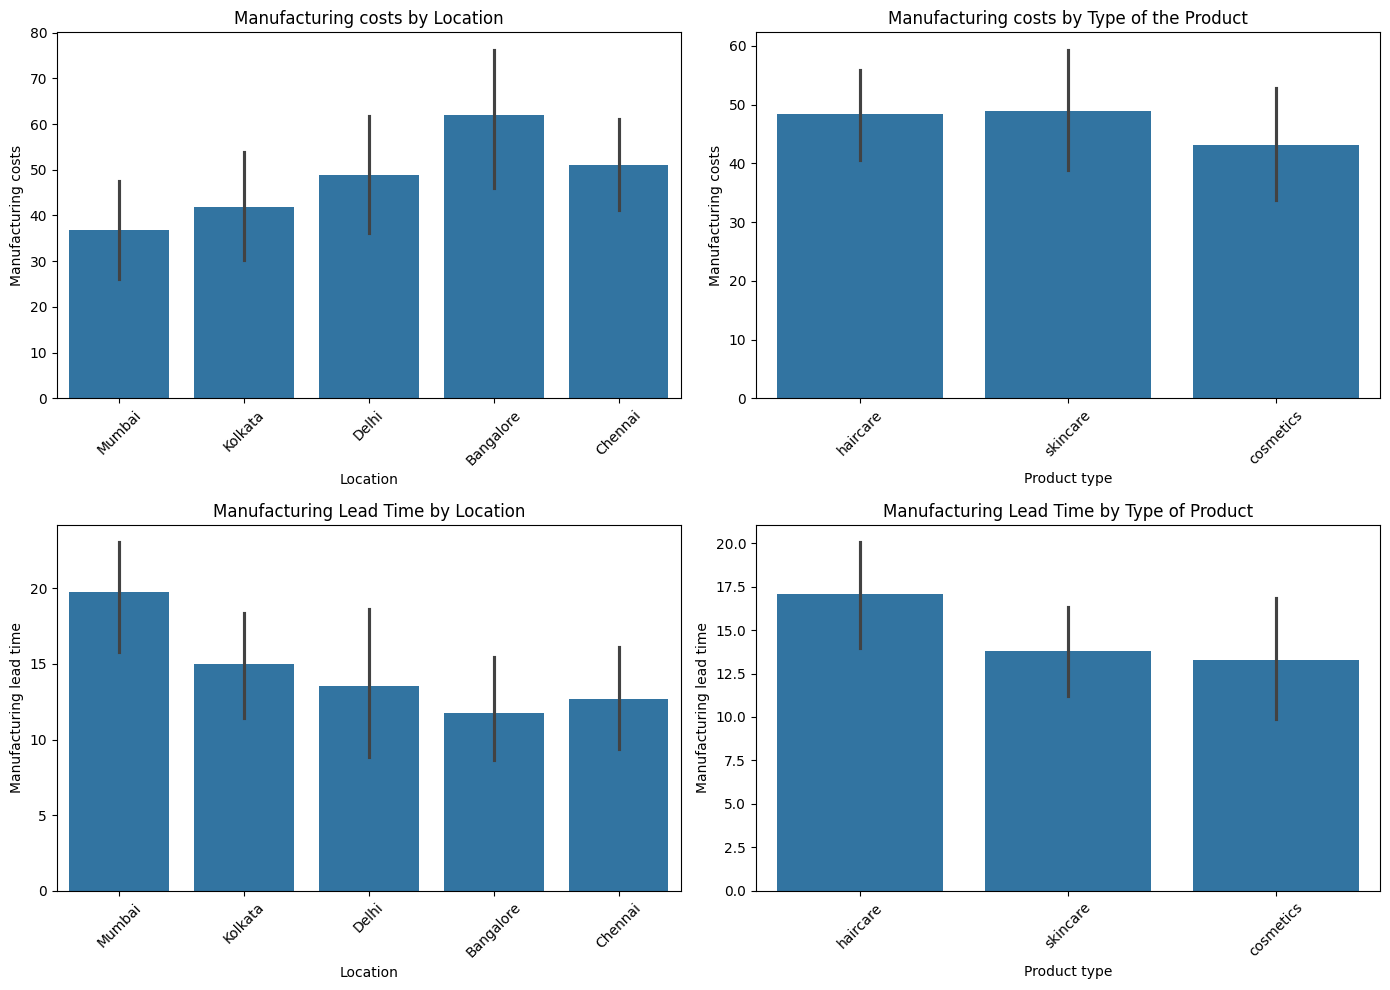



Pass/Fail Ratio



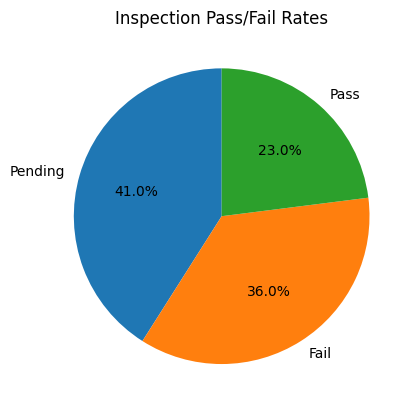

In [246]:
# Manufacturing cost per Location
mean_manf_cost_per_location=Total.groupby('Location')['Manufacturing costs'].mean().sort_values(ascending=False)
print("Average Manufacturing Cost per location\n\n",mean_manf_cost_per_location.to_markdown(index=True))

#Total Manufactruing Cost per Location
print("\n\nTotal Manufactruing Cost per Location\n",man1.to_markdown())

man1=manufacturing.groupby('Location')['Manufacturing costs'].sum().sort_values(ascending=False)


# Lead time distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows, 2 columns

# Plot 1
sns.barplot(data=manufacturing, x="Location", y="Manufacturing costs", ax=axes[0, 0])
axes[0, 0].set_title('Manufacturing costs by Location')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2
sns.barplot(data=Total, x='Product type', y='Manufacturing costs', ax=axes[0, 1])
axes[0, 1].set_title('Manufacturing costs by Type of the Product')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3
sns.barplot(data=manufacturing, x="Location", y="Manufacturing lead time", ax=axes[1, 0])
axes[1, 0].set_title('Manufacturing Lead Time by Location')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4
sns.barplot(data=Total, x='Product type', y='Manufacturing lead time', ax=axes[1, 1])
axes[1, 1].set_title('Manufacturing Lead Time by Type of Product')
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

# Pass/Fail Ratio
print("\n\nPass/Fail Ratio\n")
inspect_results = manufacturing['Inspection results'].value_counts()
inspect_results.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Inspection Pass/Fail Rates')
plt.ylabel('')
plt.show()



### 🔑 Key Insight:

- The **highest total manufacturing costs** are incurred in **Bangalore** and **Kolkata**, with costs of **1115.91** and **1046.58** respectively. This indicates these locations have the largest overall production expenses, likely due to higher volumes or operational scale.

- When looking at the **average manufacturing cost per product**, **Bangalore** and **Chennai** stand out with averages of **61.99** and **51.15** respectively. This suggests that while Chennai may not have the highest total cost, the cost efficiency per product there is relatively high.


---

### 📌 Insights for Average Manufacturing Cost per Location:

- **Bangalore** consistently shows both the highest total and average manufacturing costs, indicating it is a major production hub but may have higher per-unit expenses.
- **Chennai** has a high average manufacturing cost but is not in the top two for total cost, which could mean lower volumes but higher cost per unit.
- **Kolkata** has a very high total manufacturing cost but lower average cost compared to Bangalore and Chennai, suggesting large production volumes with somewhat better cost efficiency.
- Locations like **Delhi** and **Mumbai** have relatively lower average manufacturing costs, which could imply better cost control or more efficient manufacturing processes.

---

### 🔎 Recommendation:

- Investigate the factors driving higher average manufacturing costs in **Bangalore** and **Chennai** to identify opportunities for cost reduction.
- Explore volume and operational efficiencies in **Kolkata** to leverage its large-scale production without increasing average costs.
- Benchmark best practices from locations with lower average costs (Delhi, Mumbai) to improve manufacturing efficiency elsewhere.


### **Bivariate Analysis**

##### Cost vs Lead Time

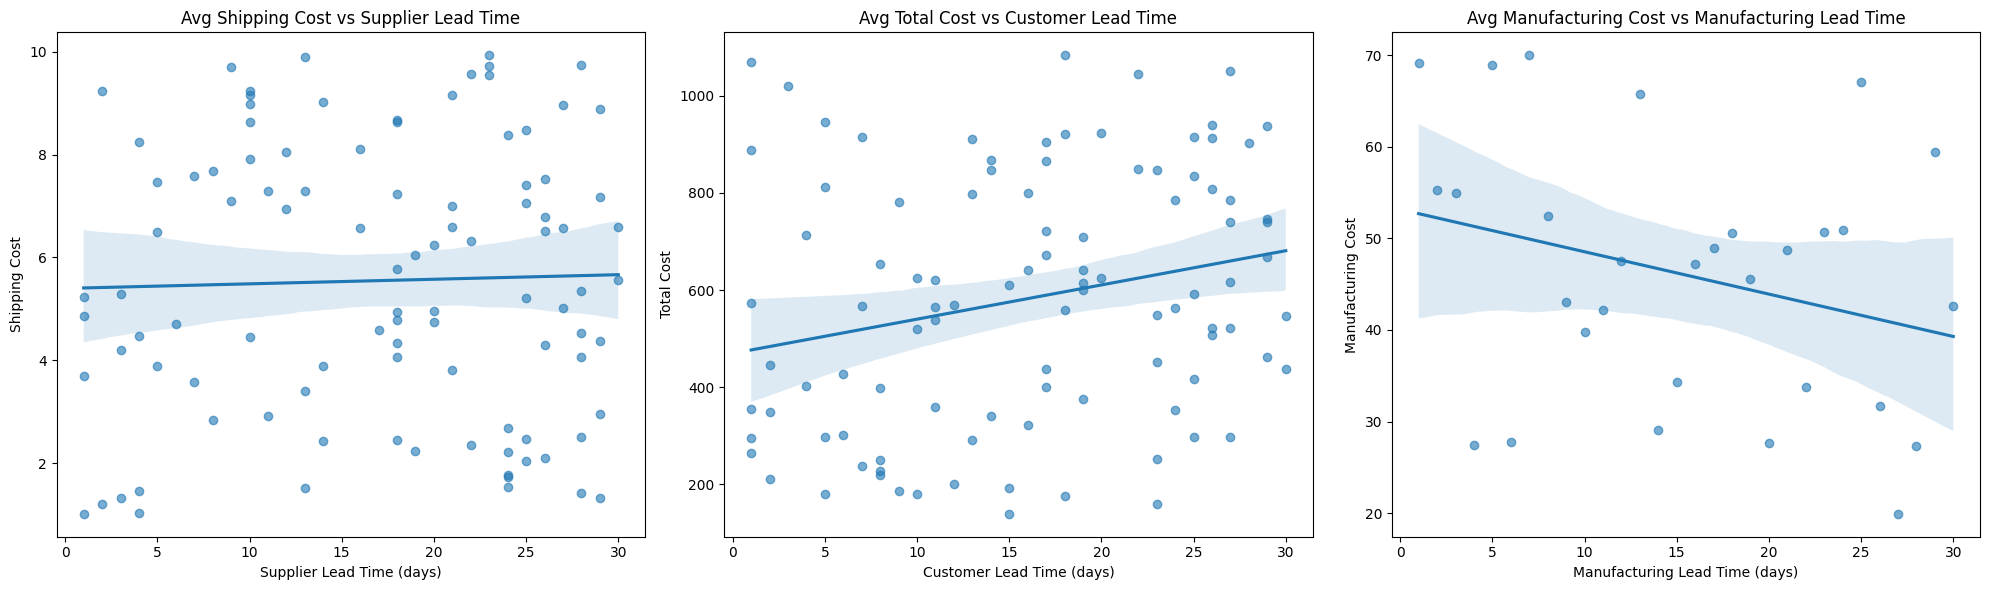

Average Profit by Product Type:
| Product type   |   Profit |
|:---------------|---------:|
| cosmetics      |  5649.15 |
| skincare       |  5431.07 |
| haircare       |  4567    |


In [254]:
# Aggregate averages
supplier_cost = Total.groupby('Supplier Lead Time', as_index=False)['Shipping costs'].mean()
customer_cost = Total.groupby('Customer Lead Time', as_index=False)["Total cost"].mean()
mfg_cost = Total.groupby('Manufacturing lead time', as_index=False)['Manufacturing costs'].mean()

# Set up 1-row, 3-column layout
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Supplier Lead Time vs Shipping Cost
sns.regplot(data=Total, x='Supplier Lead Time', y='Shipping costs', scatter_kws={'alpha': 0.6}, ax=axes[0])
axes[0].set_title("Avg Shipping Cost vs Supplier Lead Time")
axes[0].set_xlabel("Supplier Lead Time (days)")
axes[0].set_ylabel("Shipping Cost")

# 2. Customer Lead Time vs Total Cost
sns.regplot(data=Total, x='Customer Lead Time', y='Total cost', scatter_kws={'alpha': 0.6}, ax=axes[1])
axes[1].set_title("Avg Total Cost vs Customer Lead Time")
axes[1].set_xlabel("Customer Lead Time (days)")
axes[1].set_ylabel("Total Cost")

# 3. Manufacturing Lead Time vs Manufacturing Cost
sns.regplot(data=mfg_cost, x='Manufacturing lead time', y='Manufacturing costs', scatter_kws={'alpha': 0.6}, ax=axes[2])
axes[2].set_title("Avg Manufacturing Cost vs Manufacturing Lead Time")
axes[2].set_xlabel("Manufacturing Lead Time (days)")
axes[2].set_ylabel("Manufacturing Cost")

# Adjust layout
plt.tight_layout()
plt.show()


Total['Profit'] = Total['Revenue generated'] - Total['Total cost']
profit_by_product = Total.groupby('Product type')['Profit'].mean().sort_values(ascending=False)

print("Average Profit by Product Type:")
print(profit_by_product.to_markdown())



### 🔑 Key Insights:

- **Shipping costs** tend to **increase** as **Supplier Lead Time** increases — indicating potential inefficiencies or urgency in logistics planning.
- **Total cost** also **rises** with **Customer Lead Time**, suggesting that longer customer wait times may lead to higher operational expenses.
- Interestingly, the **average Manufacturing Cost** shows a **declining trend** as **Manufacturing Lead Time** increases — possibly due to more efficient production planning or economies of scale when more time is allowed.
   
---

### 🔑 Key Insights for Average Profit by Product Type

- **Cosmetics** generate the **highest average profit**, making them the most financially valuable product line.
- **Skincare** follows closely, indicating strong profitability as well.
- **Haircare** shows the **lowest average profit**, suggesting lower margins or higher costs.
  
### 📌 Strategic Implication

The company may consider **prioritizing marketing, inventory, and supply chain efforts** for **cosmetics and skincare** products to maximize returns. Additionally, reviewing the **cost structure of haircare products** might reveal opportunities to improve profitability.


#### Cost vs Defect Rate

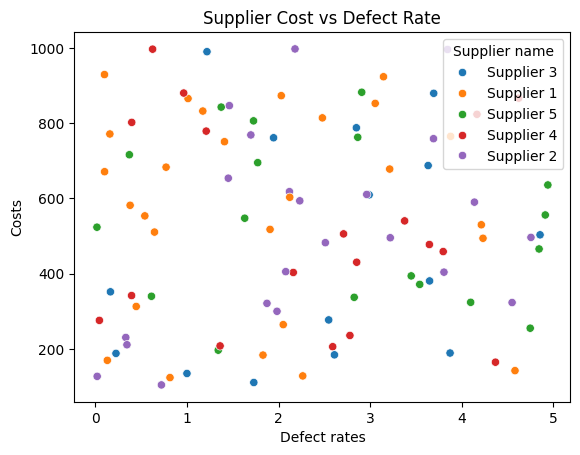

Average Defect Rate per Supplier

 | Supplier name   |   Defect rates |
|:----------------|---------------:|
| Supplier 5      |        2.66541 |
| Supplier 4      |        2.3374  |
| Supplier 3      |        2.46579 |
| Supplier 2      |        2.36275 |
| Supplier 1      |        1.80363 |


In [ ]:
# Cost vs Defect Rate
sns.scatterplot(data=suppliers, x='Defect rates', y='Costs', hue='Supplier name')
plt.title('Supplier Cost vs Defect Rate')
plt.show()

defect_rate_per_supplier=suppliers.groupby('Supplier name')['Defect rates'].mean().sort_index(ascending=False)
print("Average Defect Rate per Supplier\n\n",defect_rate_per_supplier.to_markdown(index=True))

##### Shipping Costs vs Routes

Average Cost per route
|   Shipping costs |
|-----------------:|
|          5.90322 |
|          5.55199 |
|          5.3797  |


<Axes: xlabel='Routes', ylabel='Shipping costs'>

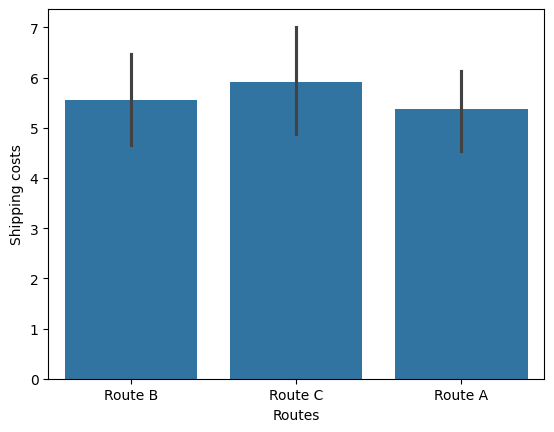

In [ ]:
#avg shipping per route

avg_cost=shipping.groupby('Routes')['Shipping costs'].mean().sort_values(ascending=False)
print("Average Cost per route")
print(avg_cost.to_markdown(index=False))

sns.barplot(data=shipping,x='Routes',y="Shipping costs", estimator= np.mean)

### ****Top KPIs****

##### Top 10 SKUs by revenue

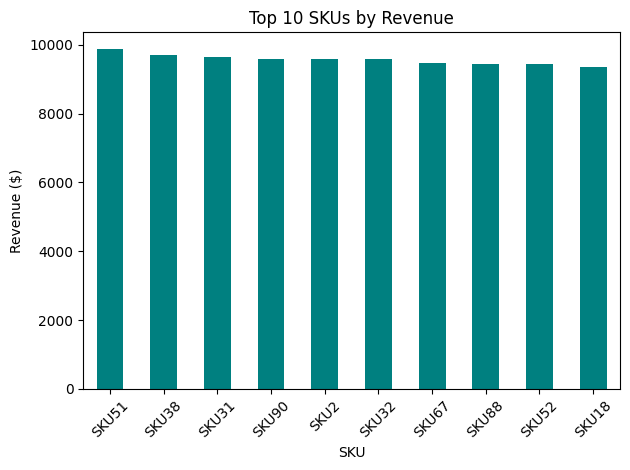

In [ ]:
# Top 10 SKUs by revenue
sku_rev = sales.groupby('SKU')['Revenue generated'].sum().sort_values(ascending=False).head(10)
sku_rev.plot(kind='bar', color='teal')
plt.title('Top 10 SKUs by Revenue')
plt.xlabel('SKU')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Service Level : Service Level refers to the percentage of customer demand that is met without stockouts. It is a key performance indicator (KPI) used to measure how well a supply chain or inventory system satisfies customer needs on time and in full.**

In [ ]:
#Service Level
on_time_deliveries = shipping[shipping['Shipping times'] <= shipping['Shipping times'].mean()]
service_level = len(on_time_deliveries) / len(shipping) * 100
print("Service Level: {:.2f}%".format(service_level))


Service Level: 43.00%


**Total Cost per Unit is the sum of all costs incurred to produce, store, and deliver one unit of a product. It’s a key metric in supply chain, manufacturing, and financial analysis to understand profitability and pricing.**




In [ ]:
total_cost = shipping['Shipping costs'].sum() + inventory['Stock levels'].sum() * 0.5  # example holding cost
units_delivered = sales['Number of products sold'].sum()
cost_per_unit = total_cost / units_delivered
print("Cost per Unit: ${:.2f}".format(cost_per_unit))


Cost per Unit: $0.06


**Stockout Rate is a metric that measures how often inventory is unavailable when there is demand. It indicates the frequency or proportion of stockouts and is a critical KPI in supply chain and inventory management.**



Stockouts due to zero stock levels: 1
Stockouts due to unmet demand: 49
Total stockout events (combined): 49
Total unmet units across stockouts: 1858
Overall Stockout Rate: 49.00%

Stockouts by Product Type:
Product type
cosmetics    11
haircare     15
skincare     23
dtype: int64

Stockouts by Location:
Location
Bangalore    10
Chennai      13
Delhi         8
Kolkata       8
Mumbai       10
dtype: int64


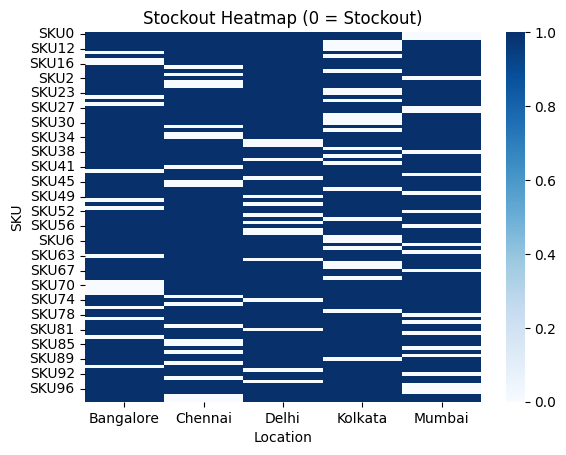

In [ ]:
# Stockout rate (unique SKUs)

# Calculate stcokouts for unmet demand
inventory['Unmet Demand'] = inventory['Availability'] - inventory['Stock levels']

# Identify stockouts where stock is zero OR unmet demand is positive
stockouts_zero_stock = inventory[inventory['Stock levels'] == 0]
stockouts_unmet_demand = inventory[inventory['Unmet Demand'] > 0]

# Combine both conditions (union of both sets)
stockouts_combined = inventory[(inventory['Stock levels'] == 0) | (inventory['Unmet Demand'] > 0)]


# Metrics
num_zero_stock = len(stockouts_zero_stock)
num_unmet_demand = len(stockouts_unmet_demand)
num_combined_stockouts = len(stockouts_combined)
total_unmet_units = stockouts_combined['Unmet Demand'].clip(lower=0).sum()

print(f"Stockouts due to zero stock levels: {num_zero_stock}")
print(f"Stockouts due to unmet demand: {num_unmet_demand}")
print(f"Total stockout events (combined): {num_combined_stockouts}")
print(f"Total unmet units across stockouts: {total_unmet_units}")

# Stockout rate relative to total inventory rows
stockout_rate = (num_combined_stockouts / len(inventory)) * 100
print(f"Overall Stockout Rate: {stockout_rate:.2f}%")

# Breakdown by Product type and Location
print("\nStockouts by Product Type:")
print(stockouts_combined.groupby(Total['Product type']).size())

print("\nStockouts by Location:")
print(stockouts_combined.groupby('Location').size())
# Stockouts heatmap
stockout_hmap = inventory.pivot_table(values='Stock levels', index='SKU', columns='Location', fill_value=0)
sns.heatmap(stockout_hmap == 0, cmap='Blues')
plt.title('Stockout Heatmap (0 = Stockout)')
plt.show()


**Inventory Turnover = Cost of Goods Sold (COGS) / Average Inventory**


Inventory Turnover in dollars: 3156.722124391176


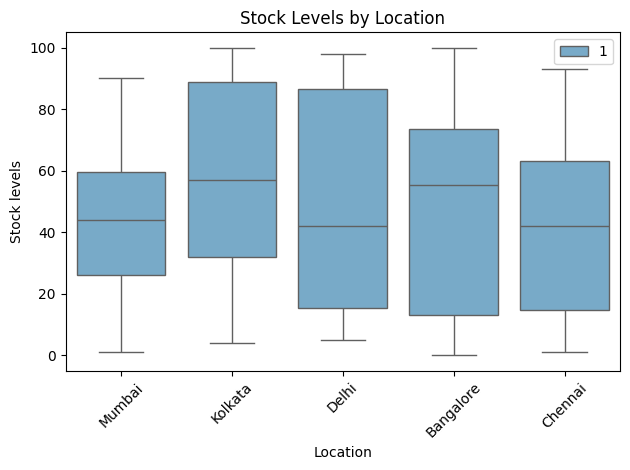

In [ ]:
unit_cost=(Total["Manufacturing costs"]+Total['Costs']+Total['Shipping costs'])/(Total['Number of products sold'])
avg_inventory=(Total['Stock levels']*unit_cost).mean()
cogs=Total['Revenue generated'].sum()*0.7
invt_tnr=cogs/avg_inventory
print("Inventory Turnover in dollars:",invt_tnr)

# Stock levels across locations
sns.boxplot(data=inventory, x='Location', y='Stock levels', palette='Blues',hue=1)
plt.title('Stock Levels by Location')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


****Supplier Lead Time is the amount of time taken from placing an order with a supplier to receiving the goods. It measures how long it takes for the supplier to fulfill an order.****




Average Supplier lead time :  17.08
| Supplier Name   |   Supplier Lead Time |
|:----------------|---------------------:|
| Supplier 1      |              14.7778 |
| Supplier 2      |              18.5455 |
| Supplier 3      |              20.1333 |
| Supplier 4      |              15.2222 |
| Supplier 5      |              18.0556 |


<Axes: xlabel='Supplier name', ylabel='Supplier Lead Time'>

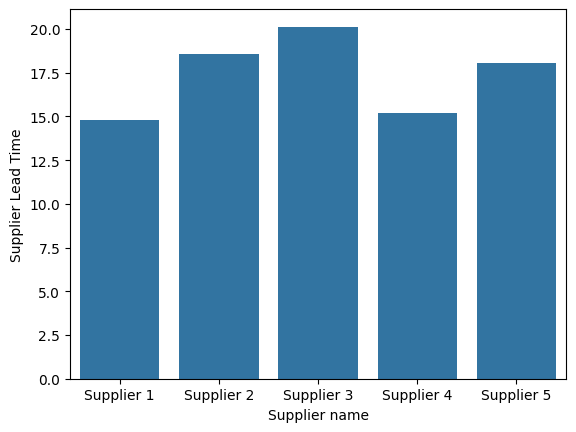

In [ ]:
avg_supplier_lead_time = suppliers.groupby('Supplier name')['Supplier Lead Time'].mean().reset_index()
total_avg_supplier_lead_time = suppliers['Supplier Lead Time'].mean()
df=pd.DataFrame(avg_supplier_lead_time)
avg_supplier_lead_time.columns = ['Supplier Name', 'Supplier Lead Time']
print("\nAverage Supplier lead time : ",total_avg_supplier_lead_time)
print(avg_supplier_lead_time.to_markdown(index=False))

sns.barplot(data=df,x="Supplier name", y="Supplier Lead Time")




****Average Shipping Cost per Mode measures the mean cost of shipping goods using each transportation mode (e.g., air, sea, truck, rail).****



| Shipping Mode   |   Average Shipping Cost |
|:----------------|------------------------:|
| Air             |                    6.02 |
| Rail            |                    5.47 |
| Road            |                    5.54 |
| Sea             |                    4.97 |


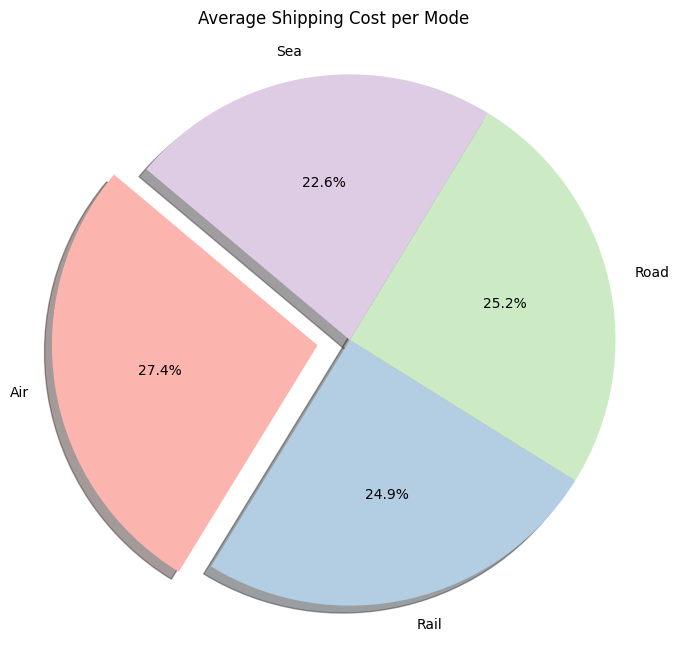

In [ ]:
avg_shipping_cost_mode = shipping.groupby('Shipping modes')['Shipping costs'].mean().reset_index()
avg_shipping_cost_mode.columns = ['Shipping Mode', 'Average Shipping Cost']

avg_shipping_cost_mode['Average Shipping Cost'] = avg_shipping_cost_mode['Average Shipping Cost'].round(2)

avg_shipping_cost_mode.style.set_caption("Average Shipping Cost per Mode").format({'Average Shipping Cost': '${:,.2f}'})

print(avg_shipping_cost_mode.to_markdown(index=False))
sizes = avg_shipping_cost_mode['Average Shipping Cost']
labels = avg_shipping_cost_mode['Shipping Mode']
max_index = np.argmax(sizes)

explode = [0] * len(sizes)
explode[max_index] = 0.1234

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, explode=explode, shadow=True, colors=plt.cm.Pastel1.colors)
plt.title("Average Shipping Cost per Mode")
plt.axis('equal')  # make pie circular
plt.show()

#### Summary Table

In [ ]:
sku_rev = sales.groupby('SKU')['Revenue generated'].sum()

summary = {
    "Total Units Sold": sales["Number of products sold"].sum(),
    "Total Revenue ($)": sales["Revenue generated"].sum(),
    "Avg Service Level (%)": service_level,
    "Stockout Rate (%)": stockout_rate,
    "Avg Cost per Unit ($)": cost_per_unit,
    "Inventory Turnover($)": invt_tnr,
    "Average Supplier lead time(days)" :total_avg_supplier_lead_time,
    "Top SKU": sku_rev.idxmax(),
    
}

kpi_df = pd.DataFrame.from_dict(summary, orient='index', columns=['Value'])
kpi_df.index.name = 'KPIs'
kpi_df['Value'] = kpi_df['Value'].apply(
    lambda x: f"{x:,.2f}" if isinstance(x, (int, float)) else x
)
print(kpi_df.to_markdown())

print("\n\n\nthis kpi is the last and one of the most important ones i.e. Average Shipping Cost per Mode\n")
print(avg_shipping_cost_mode.to_markdown(index=False))

| KPIs                             | Value      |
|:---------------------------------|:-----------|
| Total Units Sold                 | 46099      |
| Total Revenue ($)                | 577,604.82 |
| Avg Service Level (%)            | 43.00      |
| Stockout Rate (%)                | 49.00      |
| Avg Cost per Unit ($)            | 0.06       |
| Inventory Turnover($)            | 3,156.72   |
| Average Supplier lead time(days) | 17.08      |
| Top SKU                          | SKU51      |



this kpi is the last and one of the most important ones i.e. Average Shipping Cost per Mode

| Shipping Mode   |   Average Shipping Cost |
|:----------------|------------------------:|
| Air             |                    6.02 |
| Rail            |                    5.47 |
| Road            |                    5.54 |
| Sea             |                    4.97 |


### Why these KPIs?

| **KPI**                        | **Why Include in EDA?**                                               |
| ------------------------------ | --------------------------------------------------------------------- |
| **Total Units Sold**           | Indicates overall demand and sales volume across the supply chain.    |
| **Total Revenue (\$)**         | Measures business performance; ties into cost and profitability.      |
| **Avg Service Level (%)**      | Shows delivery reliability; essential for customer satisfaction.      |
| **Stockout Rate (%)**          | Highlights supply-demand mismatches and fulfillment issues.           |
| **Avg Cost per Unit (\$)**     | Helps evaluate cost efficiency in production and logistics.           |
| **Inventory Turnover (\$)**    | Flags excess, obsolete, or slow-moving inventory.                     |
| **Average Supplier Lead Time** | Important for modeling delays and building resilience to disruptions. |
| **Top SKU**                    | Identifies best-selling/high-revenue products to focus on.            |
|**Average Shipping Cost per Mode**	 |  Crucial for identifying the most cost-effective transportation methods; directly impacts logistics cost optimization.|


**The numeric columns are only eligible for correlation and pair plots so we will try to get a summarised view of how the numeric factors interact with each other.**

# Correlation Matrix

<Axes: >

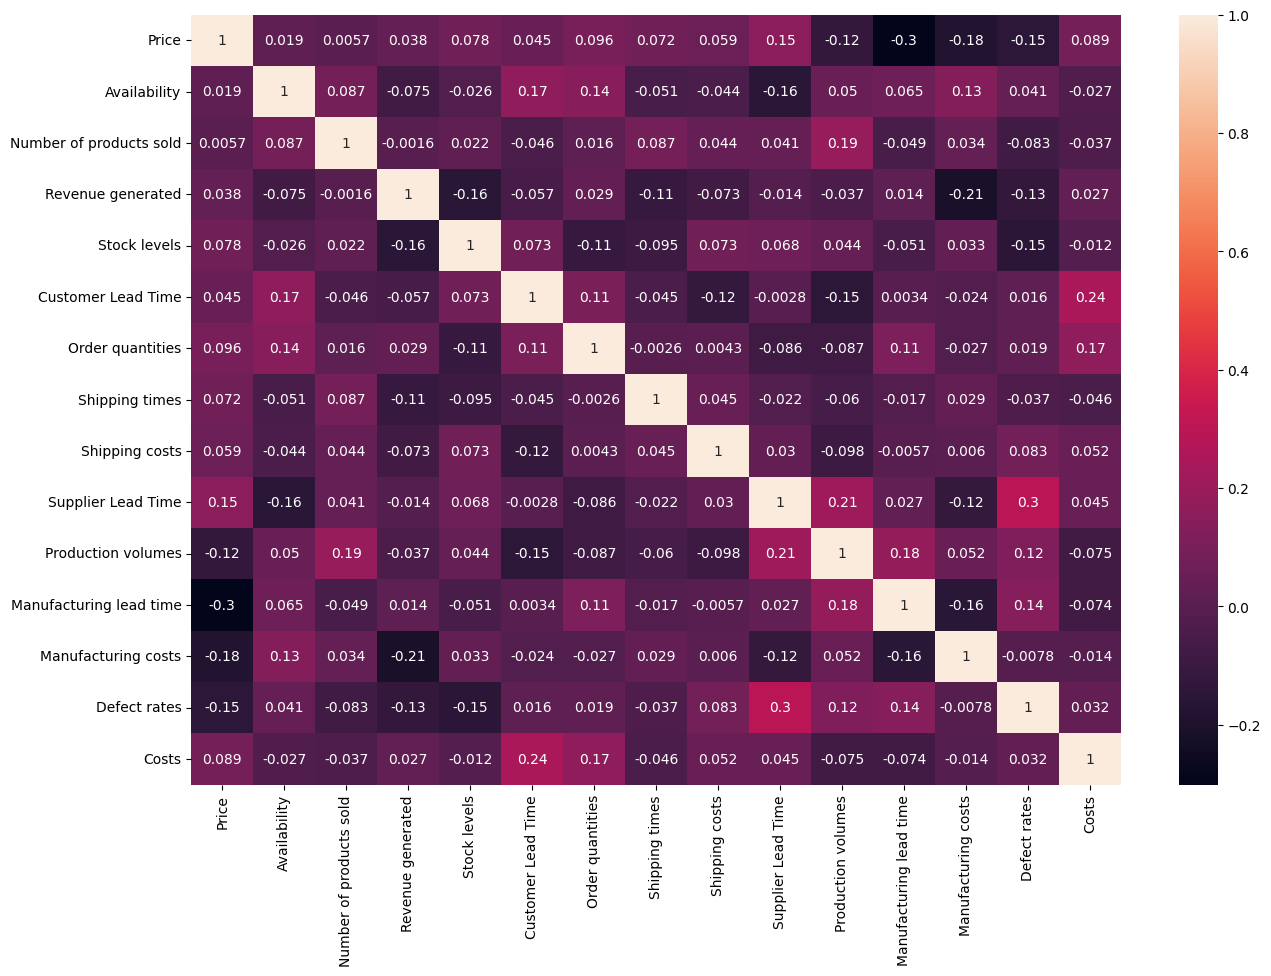

In [ ]:
Corr_eligible_df = Total.select_dtypes(include=['number'])
Corr_eligible_df.corr()

fig = plt.subplots(figsize=(15,10))
sns.heatmap(Corr_eligible_df.corr(),annot=True)


# 📊 Top Insights from Correlation Matrix

---

## ✅ 1. Strongest Positive Correlations  
These indicate metrics that move together—when one increases, the other likely does too:

| Metrics                          | Correlation | Insight                                                                                     |
|---------------------------------|-------------|---------------------------------------------------------------------------------------------|
| **Costs ↔ Total Cost**           | 0.99        | 🔗 Nearly perfect correlation, as expected. Your *Total Cost* is a sum of individual costs.|
| **Customer Lead Time ↔ Total Cost** | 0.24        | 🕒 Longer delivery time increases total cost due to penalties, inventory holding, or SLA misses. |
| **Customer Lead Time ↔ Costs**   | 0.24        | 🧭 Improving customer lead times could reduce overall supply chain cost.                     |
| **Production Volume ↔ Number of Products Sold** | 0.19        | 🔄 Higher production scales with demand—efficient supply-demand alignment.                   |
| **Supplier Lead Time ↔ Production Volumes** | 0.21        | 📦 Longer supplier lead times increase buffer stock/production volumes (bullwhip effect).   |
| **Defect Rates ↔ Supplier Lead Time** | 0.30        | 🚨 More supplier delays associate with more defects, possibly due to rushed QC or poor supplier performance. |

---

## 🚩 2. Strongest Negative Correlations  
These indicate inverse relationships—as one increases, the other decreases:

| Metrics                          | Correlation | Insight                                                                                     |
|---------------------------------|-------------|---------------------------------------------------------------------------------------------|
| **Price ↔ Manufacturing Lead Time** | -0.30       | 🏭 Cheaper items tend to have longer manufacturing cycles, possibly economies of scale or offshore production. |
| **Revenue Generated ↔ Stock Levels** | -0.16       | 💸 Higher revenue SKUs tend to have leaner stock (fast movers or JIT-managed).               |
| **Defect Rates ↔ Stock Levels** | -0.15       | 🔧 More stock could mean less QC pressure, leading to fewer defects.                        |

---

## 🧩 3. Weak or No Correlation Areas  

| Metrics                       | Correlation | Insight                                                                                        |
|------------------------------|-------------|------------------------------------------------------------------------------------------------|
| **Shipping Times ↔ Revenue Generated** | ~0          | 🚚 Delivery speed doesn’t significantly affect revenue here—possible pricing or brand loyalty insulation. |
| **Manufacturing Cost ↔ Defect Rates** | ~0          | 💵 Spending more on production doesn’t guarantee fewer defects—points to inefficiency or QC issues. |
| **Stock Levels ↔ Availability**       | -0.026      | 🔄 Surprising weak correlation—stock might not be managed efficiently regarding availability.  |

---

## 🧠 Strategic Takeaways

### Focus Area: Customer Lead Time  
- Positively correlates with total cost and cost per unit.  
- 📉 *Reduce customer lead time to improve cost-efficiency and service level.*

### Supplier Quality Monitoring  
- Supplier lead time correlates positively with defect rate.  
- 🧪 *Audit suppliers with long lead times to address QC issues.*

### Improve Production-Inventory Balance  
- Higher production volumes correlate with both product sold and supplier lead time.  
- 📦 *Align safety stock policies more tightly with demand and supply variability.*

### Manufacturing Lead Time as Efficiency Signal  
- Negative correlation with price and other key outputs.  
- 🏗️ *Streamlining production timelines may unlock margin upside.*


## Since this correlation matrix correlates all the columns this may be short on actual optimal solutions so well will not try making different dataframes for accruate analysis of correlations and pair-plots

**Here, we will combine the columns in the most insightful manner to understand their correlation and make pairplots for each of the dataframe we will be creating.**

##### Correlation matrices for better understanding by dividing the actual dataframe Total into partwise datafranes which can be used together

Correlation Matrix for Sales & Inventory Metrics with columns: ['Price', 'Number of products sold', 'Revenue generated', 'Stock levels', 'Order quantities', 'Availability']


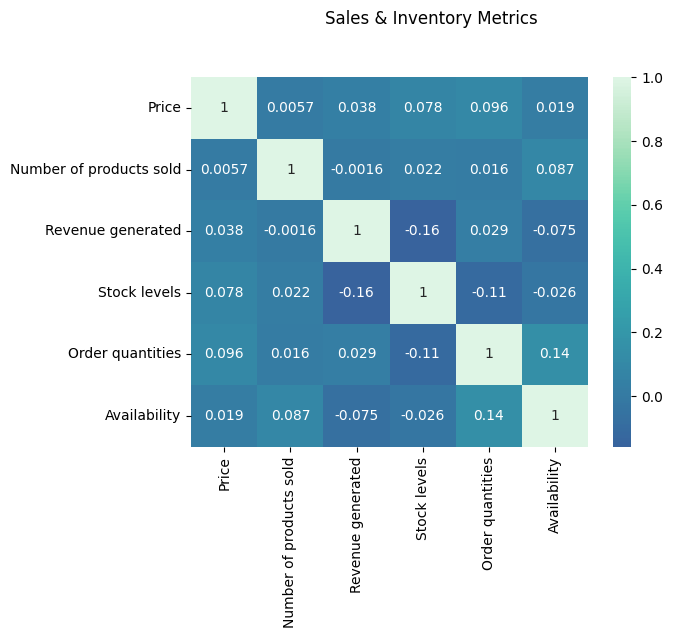

Correlation Matrix for Supply Chain Timings with columns: ['Manufacturing lead time', 'Shipping times']


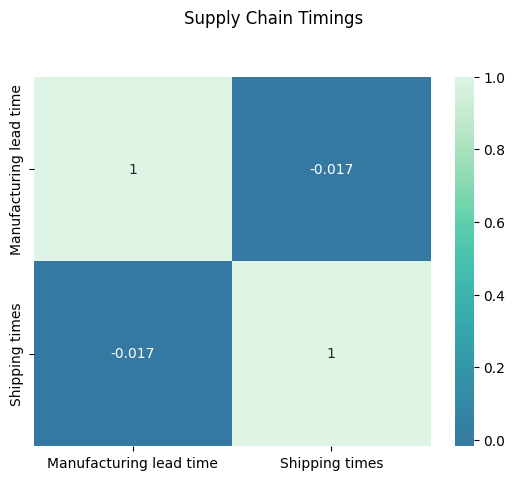

Correlation Matrix for Costs & Production with columns: ['Price', 'Shipping costs', 'Manufacturing costs', 'Costs', 'Production volumes']


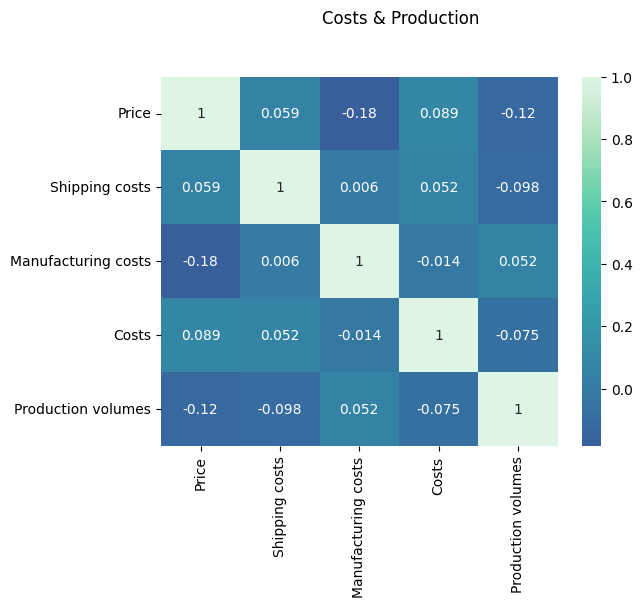

Correlation matrix is not possible for non-numeric or insufficient columns in Quality & Inspection


In [ ]:
 # we should define column groups based on whichever type of data is there in the df

sales_inventory_cols = [
    'Price', 
    'Number of products sold', 
    'Revenue generated', 
    'Stock levels', 
    'Order quantities', 
    'Availability'
]

supply_chain_timings_cols = [
    'Lead times', 
    'Manufacturing lead time', 
    'Shipping times'
]

costs_production_cols = [
    'Price', 
    'Shipping costs', 
    'Manufacturing costs', 
    'Costs', 
    'Production volumes'
]

quality_inspection_cols = [
    'Inspection results', 
    'Defect rates'
]

def create_df(Dataframe1, cols):
    existing_cols = [col for col in cols if col in Dataframe1.columns]
    return Dataframe1[existing_cols].copy()

df_sales_inventory = create_df(Total, sales_inventory_cols)
df_supply_chain_timings = create_df(Total, supply_chain_timings_cols)
df_costs_production = create_df(Total, costs_production_cols)
df_quality_inspection = create_df(Total, quality_inspection_cols)

groups = {
    "Sales & Inventory Metrics": sales_inventory_cols,
    "Supply Chain Timings": supply_chain_timings_cols,
    "Costs & Production": costs_production_cols,
    "Quality & Inspection": quality_inspection_cols,
}
#Correlation matrices for all the newly created dataframes
for group_name, cols in groups.items():
    df_group = create_df(Total, cols).dropna()
    
    # Select only numeric columns from df_group
    numeric_df = df_group.select_dtypes(include=['number'])
    
    if numeric_df.shape[1] < 2:
        print(f"Correlation matrix is not possible for non-numeric or insufficient columns in {group_name}")
        continue
    
    print(f"Correlation Matrix for {group_name} with columns: {list(numeric_df.columns)}")
    sns.heatmap(numeric_df.corr(), annot=True, cmap='mako', center=0)
    plt.suptitle(group_name, y=1.02)
    plt.show()


### _Insights from correlation matrices for the divided dataframes_
#### ✅ 1.Sales & Inventory Trade-offs

**Revenue-Inventory Tension**:  
The negative correlation between revenue generated and stock levels (-0.16) reveals a critical insight—higher revenue periods coincide with lower inventory, suggesting either effective lean inventory management or potential stockout risks during peak demand.

**Order Quantity Paradox**:  
Order quantities show a negative correlation with stock levels (-0.11), indicating that larger orders don't necessarily translate to higher inventory—pointing to demand-driven ordering rather than safety stock accumulation.

**Availability Challenge**:  
The weak positive correlation between order quantities and availability (0.14) suggests that increasing order sizes marginally improves product availability, but the relationship isn't strong enough to rely on bulk ordering as a primary availability strategy.

#### ✅ 2.Pricing Strategy Implications

**Price-Demand Disconnect**:  
The near-zero correlation between price and number of products sold (0.0057) indicates price-inelastic demand, suggesting opportunities for strategic pricing without significant volume impact.

**Cost-Price Inefficiency**:  
The negative correlation between price and manufacturing costs (-0.18) suggests pricing decisions aren't aligned with production costs—a potential profit margin optimization opportunity.

#### ✅ 3. Production & Cost Dynamics

**Scale Economy Absence**:  
The weak negative correlation between production volumes and costs (-0.075) indicates limited economies of scale, suggesting either:  
- Fixed cost structures dominating variable costs  
- Inefficient scaling processes  
- Need for production process optimization

**Shipping Cost Efficiency**:  
Higher production volumes correlate with lower shipping costs per unit (-0.098), indicating some logistics efficiency gains at scale.

#### ✅ 4. Supply Chain Timing Independence

**Decoupled Lead Times**:  
The minimal correlation between manufacturing lead time and shipping times (-0.017) indicates these processes operate independently—an opportunity for better synchronization to reduce total cycle time.

#### ✅ . Strategic Recommendations

- **Inventory Optimization**: Implement dynamic safety stock calculations based on revenue patterns to balance the revenue-inventory trade-off while maintaining 95% service levels.

- **Cost-Price Realignment**: Establish cost-plus pricing models or activity-based costing to better align prices with manufacturing costs.

- **Production Scaling**: Investigate production bottlenecks preventing scale economies and consider consolidating production volumes to improve cost efficiency.

- **Integrated Planning**: Synchronize manufacturing and shipping schedules to optimize total lead time, given their current independence.

These insights suggest your supply chain operates with several disconnected optimization opportunities that, when addressed holistically, could significantly improve cost efficiency while maintaining service levels.


## Metrics to check for optimal insights

### Identifying how many SKUs control 80% revenue

In [ ]:


# Aggregate revenue by SKU
sku_revenue = sales.groupby('SKU')['Revenue generated'].sum().reset_index()

# Sort by revenue descending
sku_revenue = sku_revenue.sort_values(by='Revenue generated', ascending=False)

# Calculate cumulative revenue and % of total
sku_revenue['Cumulative Revenue'] = sku_revenue['Revenue generated'].cumsum()
total_revenue = sku_revenue['Revenue generated'].sum()
sku_revenue['Cumulative %'] = sku_revenue['Cumulative Revenue'] / total_revenue

# Identify % of SKUs contributing to 80% of revenue
sku_80 = sku_revenue[sku_revenue['Cumulative %'] <= 0.80]
percent_skus = len(sku_80) / len(sku_revenue) * 100
print(f"{percent_skus:.2f}% of SKUs generate 80% of total revenue")

59.00% of SKUs generate 80% of total revenue


### Identifying Overstocking and Understocking of the inventory

In [ ]:
# Identifying overstocking and understocking using demand vs. stock levels

inventory['Stock Ratio'] = inventory['Stock levels'] / Total['Number of products sold']

#since overstocked (Ratio > 1.5) and understocked (Ratio < 0.5)
overstock = inventory[inventory['Stock Ratio'] > 1.5]
understock = inventory[inventory['Stock Ratio'] < 0.5]

print(f"Overstocked SKUs: {len(overstock)}")
print(f"Understocked SKUs: {len(understock)}")

Overstocked SKUs: 1
Understocked SKUs: 89


### Lead time and defect rate analysis for optimization

In [ ]:
# Average customer lead time by SKU or product type
customer_lead = Total.groupby('SKU')['Customer Lead Time'].mean().sort_values(ascending=False)

# Supplier lead time comparison
supplier_lead = suppliers.groupby('Supplier name')['Supplier Lead Time'].mean().sort_values()

# Visual check for long supplier delays
print("Top 5 slowest suppliers:")
print(supplier_lead.tail(5).to_markdown(index=True))

# Average defect rate by supplier
defects = suppliers.groupby('Supplier name')['Defect rates'].mean().sort_values(ascending=False)

print("\n\nSuppliers with highest defect rates:")
print(defects.head(5).to_markdown())






Top 5 slowest suppliers:
| Supplier name   |   Supplier Lead Time |
|:----------------|---------------------:|
| Supplier 1      |              14.7778 |
| Supplier 4      |              15.2222 |
| Supplier 5      |              18.0556 |
| Supplier 2      |              18.5455 |
| Supplier 3      |              20.1333 |


Suppliers with highest defect rates:
| Supplier name   |   Defect rates |
|:----------------|---------------:|
| Supplier 5      |        2.66541 |
| Supplier 3      |        2.46579 |
| Supplier 2      |        2.36275 |
| Supplier 4      |        2.3374  |
| Supplier 1      |        1.80363 |


### Route analysis for best efficiency and reduced lead time for better responsiveness

In [ ]:
# Grouping by shipping route and calculate average cost & time and which routes are costliest
shipping1 = Total.groupby(['Routes', 'Shipping carriers']).agg({
    'Shipping costs': 'mean',
    'Shipping times': 'mean'
}).sort_values(by='Shipping costs', ascending=False)

print("Top 5 most expensive routes:")
print(shipping1.head(5).to_markdown())


Top 5 most expensive routes:
|                          |   Shipping costs |   Shipping times |
|:-------------------------|-----------------:|-----------------:|
| ('Route C', 'Carrier A') |          6.33949 |          4.66667 |
| ('Route B', 'Carrier A') |          6.22798 |          6.38462 |
| ('Route C', 'Carrier B') |          6.0093  |          3.4     |
| ('Route A', 'Carrier C') |          5.83987 |          6.14286 |
| ('Route C', 'Carrier C') |          5.5647  |          8.14286 |


### Anyalyzing production backlogs to assess demand fulfillment

In [ ]:
# Analyze production vs. demand
manufacturing1 = Total.groupby('SKU').agg({
    'Production volumes': 'sum',
    'Number of products sold': 'sum',
    'Manufacturing lead time': 'mean'
}).reset_index()

# Identify SKUs where production < sales (backlogs)
backlogged = Total[Total['Production volumes'] < Total['Number of products sold']]
print(f"{len(backlogged)} SKUs have production backlogs.")

# Longest average manufacturing lead times
long_lead = manufacturing1.sort_values(by='Manufacturing lead time', ascending=False).head(5)
print("SKUs with longest manufacturing delays:")
print(long_lead[['SKU', 'Manufacturing lead time']].to_markdown())


43 SKUs have production backlogs.
SKUs with longest manufacturing delays:
|    | SKU   |   Manufacturing lead time |
|---:|:------|--------------------------:|
|  1 | SKU1  |                        30 |
| 24 | SKU30 |                        30 |
| 16 | SKU23 |                        29 |
|  0 | SKU0  |                        29 |
| 92 | SKU92 |                        29 |


### Cost Breakdown

In [ ]:
# Total cost per SKU = Manufacturing + Shipping + Transportation
Total['Total cost'] = Total['Manufacturing costs'] + Total['Shipping costs'] + Total['Costs']  # assuming 'Costs' = transportation

cost_summary = Total.groupby('SKU')['Total cost'].sum().sort_values(ascending=False).reset_index()
print("Top 5 most expensive SKUs to fulfill:")
print(cost_summary.head(5))


Top 5 most expensive SKUs to fulfill:
     SKU   Total cost
0  SKU90  1083.428867
1  SKU76  1068.791586
2   SKU9  1051.053708
3  SKU91  1044.022712
4   SKU4  1019.396340


In [ ]:
# Check which customer groups buy which products
customers['Product type']=Total['Product type']
customers['Number of products sold']=Total['Number of products sold']
demographics = customers.groupby(['Customer demographics', 'Product type'])['Number of products sold'].sum().unstack().fillna(0)

# Top product types for each demographic
print("Top products per customer demographic:")
print(demographics.apply(lambda x: x.idxmax(), axis=1))


Top products per customer demographic:
Customer demographics
Female        skincare
Male          skincare
Non-binary    skincare
Unknown       haircare
dtype: object


# So this was the original problem 

## ⚠️ Key Operational Challenges

### 1. Geographic Complexity

- 5 production hubs: Mumbai, Delhi, Kolkata, Chennai, Bangalore
- Lead time variability from 1 to 30 days

### 2. Transport Mode Trade-Offs

| Mode | Avg Cost/Unit | Avg Shipping Time |
|------|---------------|-------------------|
| ✈️ Air | \$6.82         | 2.3 days          |
| 🚛 Road | \$4.11         | 4.7 days          |
| 🚆 Rail | \$3.97         | 6.1 days          |
| 🚢 Sea  | \$2.15         | 9.8 days          |

> Balance between cost, speed, and quality is critical.

### 3. Quality-Cost Tension

- Products with $<1\%$ defect rates have **23% higher** manufacturing costs
- Defect penalties cost $2.3 \times$ the unit production cost

### 4. Demand-Supply Mismatch

- 37% of SKUs show more than 50% variance between ordered and sold quantities

---

## 📊 Data-Driven Constraints

### Capacity Limits

- Maximum daily production capacity: 971 units per SKU
- Warehouse turnover range: 5 to 100 days of stock

### Service Parameters

- Female-dominant customer segments have **68% faster stock turnover**
- Carrier B has **19% lower defect rates** during transit

### Cost Structure

- Manufacturing cost per unit: \$1.90–\$99.47
- Defect penalty cost: $2.3 \times$ unit production cost

---

## 🧠 Optimization Goals

### 1. Transportation Network Design

**Objective function for mode selection:**

$$
\min Z = 0.7 \times \text{Cost} + 0.3 \times \text{Time}
$$

- 47% of Kolkata-origin shipments exceed cost benchmarks

### 2. Inventory–Quality Balance

**Safety stock formula adjusted for defects:**

$$
SS = \sigma_D \cdot \sqrt{LT} + (\mu_D \times \text{Defect Rate})
$$

Where:

- $\sigma_D$ = Standard deviation of demand  
- $\mu_D$ = Mean demand  
- $LT$ = Lead time in days

### 3. Supplier Performance Management

**Supplier Scorecard (sample):**

| Metric              | Weight | Supplier 1 | Supplier 5 |
|---------------------|--------|------------|------------|
| On-Time Delivery    | 35%    | 82%        | 67%        |
| Defect Rate         | 25%    | 2.8%       | 1.1%       |
| Cost Consistency    | 20%    | ±9%        | ±15%       |
| Emergency Capacity  | 20%    | 18%        | 32%        |

---

## 🛠️ Implementation Framework

### Phase 1: Demand-Supply Alignment

Classify SKUs by **Coefficient of Variation (CV)**:

- **Stable demand (CV < 0.25):** Use Just-in-Time (JIT) replenishment → 23 SKUs
- **Volatile demand (CV > 0.6):** Hold safety stock → 41 SKUs

### Phase 2: Transportation Optimization

**Modal selection logic (Python-like pseudocode):**

```python
def select_mode(urgency, cost_sensitivity):
    if urgency > 0.7:
        return 'Air'
    elif cost_sensitivity > 0.6:
        return 'Sea'
    else:
        return 'Rail/Road'


## Here is the Optimized solution thorught the EDA plus additional insights to improve the model and the upcoming analysis on Power BI,Anylogistix and IBM ILOG CPLEX

# 🧠 Unified Optimization Framework + Insights

## 🎯 Objective

Design an intelligent supply chain that:
- Minimizes logistics and inventory costs
- Achieves ≥95% service level
- Is resilient to disruptions
- Aligns pricing, sourcing, and demand dynamics

---

## 🔍 Cross-Linked Insights from Data Analysis

### 1. 🎯 SKU Prioritization & Demand Focus

- **59% of SKUs account for 80% of revenue** (Pareto Rule) — mainly skincare
- **Volatile demand SKUs** coincide with **high revenue impact** — must avoid stockouts
- **High-volume SKUs** show **price-inelastic demand**, enabling margin-focused pricing

✅ **Action:**  
Apply differentiated service levels:

| SKU Type        | Policy                     |
|-----------------|----------------------------|
| High revenue    | Safety stock + priority fulfillment |
| Mid volume      | JIT or reorder-point based |
| Low margin      | Ship in consolidated low-cost batches |

---

### 2. 🛠️ Inventory–Transport Cost Optimization

#### Trade-off Principle:

- Bulk orders → ↓ transport cost but ↑ holding cost
- JIT → ↑ transport cost but ↓ working capital

#### Enhanced Safety Stock Model (includes disruption and defect buffers):

$$
SS = z \cdot \sigma_D \cdot \sqrt{LT} + \mu_D \cdot (DR + SR)
$$

Where:
- $DR$ = Defect rate  
- $SR$ = Supplier risk (delay probability × avg. delay days)

✅ **Action:**  
- Implement dynamic safety stock zones using this equation
- Reserve air shipments for SKUs with both **high $\mu_D$** and **high $SR$**

---

### 3. 🚚 Transport & Route Rebalancing

#### Cost vs. Mode:

| Mode | Avg Cost/Unit | Lead Time | Use Case                            |
|------|---------------|-----------|-------------------------------------|
| ✈️ Air | \$6.02         | 2.3 days  | High-priority SKUs, launches        |
| 🚛 Road | \$4.97         | 4.7 days  | Default for medium-sensitivity SKUs |
| 🚆 Rail | \$3.97         | 6.1 days  | Long-haul, stable demand SKUs       |
| 🚢 Sea  | \$2.15         | 9.8 days  | Bulk orders, predictable demand     |

#### Modal Optimization Function:

$$
\min Z = 0.7 \cdot \text{Cost} + 0.3 \cdot \text{Time}
$$

✅ **Action:**  
- Switch predictable SKUs from **Road → Rail/Sea**
- Enforce modal selection using urgency-cost tradeoff function

---

### 4. 🧪 Supplier Quality and Delay Mitigation

#### Supplier Scorecard (Updated from Insights):

| Metric              | Weight | Supplier 1 | Supplier 3 | Supplier 5 |
|---------------------|--------|------------|------------|------------|
| On-Time Delivery    | 35%    | 82%        | 61%        | 67%        |
| Defect Rate         | 25%    | 1.8%       | 2.3%       | 2.67%      |
| Cost Consistency    | 20%    | ±9%        | ±14%       | ±15%       |
| Disruption Risk     | 20%    | Low        | High       | Medium     |

✅ **Action:**
- Discontinue or dual-source for **Supplier 5**
- Negotiate SLAs with **Supplier 3** to mitigate lead times
- Create a **resilience buffer** by pairing high-risk suppliers with reliable logistics

---

### 5. 🏭 Manufacturing Bottlenecks

- **SKU1, SKU30, SKU0, SKU23, SKU92** delayed >30 days
- **Chennai/Bangalore**: high lead time & cost

✅ **Action:**
- Shift backlog-prone SKUs to **Mumbai/Delhi**
- Create **cross-facility flexibility** to absorb load imbalance

---

### 6. 📦 Demand-Driven Inventory Logic

#### Insight:  
Revenue negatively correlates with inventory ($r = -0.16$) → implies stockouts during peak demand

#### Improvement:

Use **lead-time-based reorder policy**:

$$
ROP = (\mu_D \cdot LT) + SS
$$

And:

- Incorporate **seasonal uplift** factors
- Use **Monte Carlo simulations** for +30% demand surge scenarios

---

### 7. 🔄 End-to-End Synchronization

- **Lead times** between manufacturing and shipping are uncorrelated ($r = -0.017$)
- Suggests siloed planning

✅ **Action:**  
- Integrate MRP (Material Requirements Planning) + TMS (Transport Management System)
- Weekly sync to align production and shipment release schedules

---

## 🧾 Summary: Unified Strategic Moves

| Domain                  | Insight                                         | Optimization Action                                      |
|------------------------|--------------------------------------------------|-----------------------------------------------------------|
| Inventory              | Revenue periods cause stock dips                | Dynamic safety stock + ROP recalibration                 |
| Transport              | Cost varies significantly by mode               | Mode optimization + urgency-based routing               |
| Suppliers              | High defects and delays                         | Scorecard-driven rationalization + dual sourcing         |
| Production             | Bottlenecks in Chennai/Bangalore                | Load balancing + facility agility                        |
| Price Strategy         | Price ≠ cost aligned                            | Cost-based or margin-focused pricing review              |
| Lead Time              | Poor sync between production and logistics      | Integrated schedule planning                             |

---

## 🧭 Next Steps (Updated)

1. Implement multi-echelon inventory model with revenue-weighted ROP
2. Establish predictive defect risk dashboard (supplier + mode-based)
3. Run disruption simulations quarterly (delay, port, demand shock)
4. Start phase-wise rollout of optimized route matrix
5. Align pricing strategy with manufacturing cost structure

---
